From linear models to machine learning
===
- Machine learning can be intimidating, but all of the most complex concepts can be broken down into single, less complex chunks. The complexity from ML techniques emerges when we take simple blocks and chain them together.
- No technique embodies this more from neural networks - powerful universal function approximators, driving the current state of the art in ML.
- Broken down to their simplest unit, the 'neuron', these networks are nothing more than combinations of simple non-linear units, with the emergent complexity coming from chaining arbitrary numbers of them together. This is not helped by current ML frameworks abstracting this away under `Layer` APIs and wrapping the entire training process under `model.fit()` or similar.

- This notebook starts off in (hopefully) familiar territory of linear models (straight line fits), and builds on these to build simple neural networks from scratch.
- We will use the [JAX]() linear algebra framework to power this, essentially `numpy`-like syntax, but with powerful automatic differentiation and compilation routines. This can provide C-level performance, but with the nice programming experience we're all familiar with

In this notebook:
- We will build and train from scratch a simple neural network, to demystify the process and build intuition for how such networks work, train, and classify.
- We will apply this neural network to astronomical data.
- Features, feature extraction, PCA

In [1]:
import random

import jax
jax.config.update("jax_enable_x64", True)  # force JAX to use 64-bit mode
jnp = jax.numpy

# init our RNG key, for later.
rng_key = jax.random.PRNGKey(42)

import matplotlib.pyplot as plt

Linear models
---
Let's start right at the beginning, with among the simplest statistical regression models that comes to mind.

The first step is to generate a test dataset - see below:

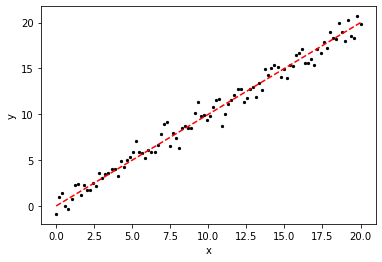

In [2]:
x = jnp.linspace(0, 20, 100)
m_true = 1
b_true = 0

y_true = m_true * x + b_true
y_obs = y_true + jax.random.normal(rng_key, shape=x.shape)

plt.scatter(x, y_obs, c='k', s=5)
plt.plot(x, y_true, c='r', ls='--')
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Analytic solution (linear least squares)
---
In the case of linear models, we're lucky that an analytic solution exists -- linear least squares.
We can write the model above as a matrix equation.

$$ \bf{A}x = \bf{b}$$
where $A$ is the 'design' matrix, and takes the form
$$ \begin{pmatrix}1 & x_0 \\1 & x_1 \\1 & x_2 \\\vdots & \vdots \\1 & x_n \\\end{pmatrix}$$
and the values of $b$ represent the y-values of our points.
$x$ is what we are solving for, and contains the coefficients which when multiplied with $A$ minimise $||Ax - b||$, where $|| ||$ denotes the squared mean.

Note in the cells below, the `@` operator is infix notation to denote matrix multiplication. You can read `a @ b` as `np.matmul(a, b)` if it helps with understanding.

In [3]:
design_matrix = jnp.array([jnp.ones_like(x), x]).T
obs_matrix = y_obs[jnp.newaxis, :].T

0.205
0.986


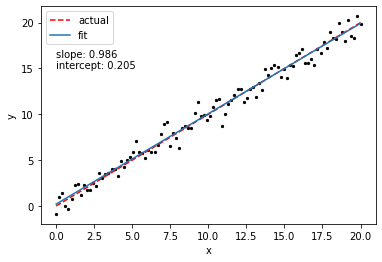

In [15]:
# Thankfully, there's a convenience function to compute this for us
coeffs, _, _, _ = jnp.linalg.lstsq(design_matrix, obs_matrix)

# Essentially this does the below under the hood - the `lstsq` function does things more cleverly to avoid singular matrices and speeds things up with Cholesky decomposition
coeffs_handcoded = jnp.linalg.inv(design_matrix.T @ design_matrix) @ design_matrix.T @ obs_matrix

y_pred = design_matrix @ coeffs_handcoded

for c in coeffs.flatten():
    print(f"{c:.3f}")

plt.scatter(x, y_obs, c='k', s=5)
plt.plot(x, y_true, c='r', ls='--', label='actual')
plt.plot(x, y_pred, c='C0', ls='-', label='fit')

_intercept, _slope = coeffs_handcoded.flatten()
plt.text(0, 15, f"slope: {_slope:.3f} \nintercept: {_intercept:.3f}")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

Some observations
---
- Note that we do not exactly recover the coefficients we put in (i.e. `m_true`, `b_true`) in the cell where we create the dataset. This is because we added noise, and least squares does not recover a unique set of coefficients, only those that minimise the Euclidean norm of the residuals.

Numerical solution
---
- Sometimes we may not have linear solutions to our problems - i.e. in the most general case, any non-separable model is significantly more difficult to solve. Here we need to turn to iterative methods.

- In the following section, we introduce a few concepts which we'll come back to continually through this workshop. Don't worry if you don't fully follow now, we'll come back to these and elaborate further.

<div class="alert alert-block alert-info">
<b>Loss function</b>

The loss function is a general concept in machine learning, and evaluates how well a given model's predictions correspond to the dataset it is trying to approximate. Generally, the lower the value of the loss function, the better the fit. This is also known as the cost function or error function.
As astronomers, you're likely already familiar with one cost function: the chi-squared statistic. This function takes a specific set of parameters, makes a model prediction, and compares this to some input data to compute the 'goodness of fit'. By minimising the 'cost', we find the best-fitting parameters.
The chi-squared statistic has a close relative in the ML literature: the L2 or mean-squared error loss. This can be written as
$$ \mathcal{L} = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2 $$
where $y_i$ is the ith datapoint, and $\hat{y}_i$ is the model's prediction for the ith datapoint.
We will implement the mean squared error loss below, but there are many more loss functions, including for classification tasks, which we will come to later.
</div>

In [19]:
def linear_model(pars, x, y):
    m, c = pars
    return m*x + c

def loss_function(pars: list, x: jnp.ndarray, y: jnp.ndarray):
    y_model = linear_model(pars, x, y)
    return jnp.mean(jnp.square(y - y_model))

For this section, let's analytically compute the derivatives! Don't worry, this is just to show you what's going on - `JAX` can do this automatically for us going forward.

$$ \frac{d\mathcal{L}}{dm} = -2\sum_{i=1}^{N} (y_i - \hat{y}_i) x$$
$$ \frac{d\mathcal{L}}{dc} = -2\sum_{i=1}^{N} (y_i - \hat{y}_i)$$

In [20]:
def dloss_dm(pars, x, y):
    m, c = pars
    y_model = linear_model(pars, x, y)
    return -2 * jnp.mean((y - y_model)*x)

def dloss_dc(pars, x, y):
    m, c = pars
    y_model = linear_model(pars, x, y)
    return -2 * jnp.mean((y - y_model))

# to make this easier to follow, let's write a function that returns these as an array.
def dloss_vec(pars, x, y):
    dldm = dloss_dm(pars, x, y)
    dldc = dloss_dc(pars, x, y)

    return jnp.array([dldm, dldc])

Gradient descent
---
- We now have a loss function, and gradients of it with respect to our parameters. Now to optimise the parameters using gradient descent.

<div class="alert alert-block alert-info">
<b>Gradient descent</b>

Gradient descent is a first-order (in gradient) optimisation technique used to minimise functions.

At each iteration $i$, the next position is computed according to the following update rule:
$$ x_{i+1} = x_{i} - \eta \nabla f(x_{i})$$
where $\eta$ is a dimensionless quantity known as the 'learning rate', which controls the size of the steps taken, and $\nabla f(x_{i})$ is the gradient of $f$ with respect to $x$ at the current timestep.
</div>

- See the gradient descent notebook for a fuller description of gradient descent, along with more complex discussion of the steps below

0 steps: loss 115.848 / gradnorm: 248.966


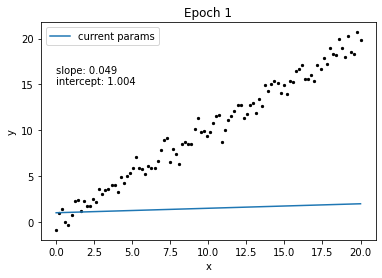

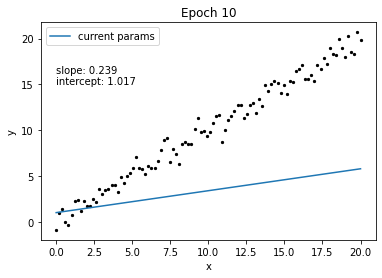

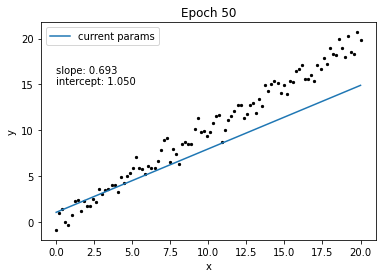

100 steps: loss 1.339 / gradnorm: 16.210


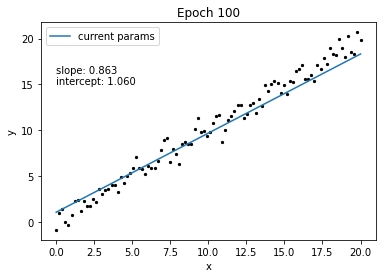

200 steps: loss 0.852 / gradnorm: 1.140
300 steps: loss 0.849 / gradnorm: 0.436
400 steps: loss 0.847 / gradnorm: 0.428
500 steps: loss 0.845 / gradnorm: 0.426


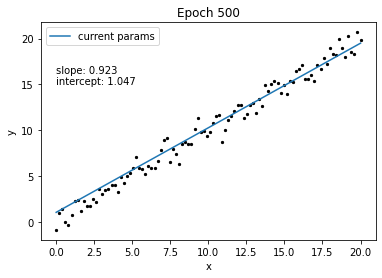

600 steps: loss 0.843 / gradnorm: 0.424
700 steps: loss 0.841 / gradnorm: 0.422
800 steps: loss 0.839 / gradnorm: 0.420
900 steps: loss 0.838 / gradnorm: 0.418


In [40]:
m_init = 0
c_init = 1
init_pars = jnp.array([m_init, c_init])
_pars = init_pars

eta = 1e-4
n_optimisation_steps = 1000

loss_arr = jnp.zeros(n_optimisation_steps)
grad_arr = jnp.zeros(n_optimisation_steps)

for n in range(n_optimisation_steps):
    _loss = loss_function(_pars, x, y_obs)
    loss_arr = loss_arr.at[n].set(_loss)

    _loss_grads = dloss_vec(_pars, x, y_obs)
    grad_arr = grad_arr.at[n].set(jnp.linalg.norm(_loss_grads))
    _pars -= eta * _loss_grads

    if not (n % 100):
        print(f"{n} steps: loss {_loss:.3f} / gradnorm: {jnp.linalg.norm(_loss_grads):.3f}")

    # plot at specific intervals
    if n in [1, 10, 50, 100, 500, 1000, 2000]:
        _slope, _intercept = _pars
        plt.scatter(x, y_obs, c='k', s=5)
        plt.text(0, 15, f"slope: {_slope:.3f} \nintercept: {_intercept:.3f}")
        plt.plot(x, _intercept + _slope*x, label='current params')
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title(f"Epoch {n}")
        plt.legend()
        plt.show()

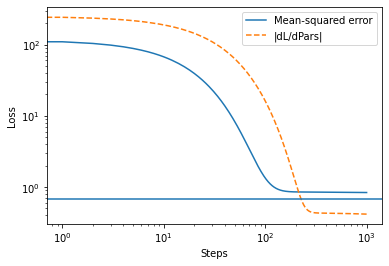

In [41]:
analytic_loss = loss_function([m_true, b_true], x, y_obs)

plt.plot(loss_arr, label='Mean-squared error')
plt.plot(grad_arr, ls='--', label='|dL/dPars|')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.axhline(analytic_loss)
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

Stochastic gradient descent
---
- What happens when our model/data is big?

- Inverting a matrix (as required for least squares in the $(X^T X)^{-1}$ step) has algorithmic complexity of $O(N^3)$ - this means that if we double the number of matrix elements $N$, the computational time/number of operations is multiplied by 8! This quickly becomes an issue for linear models with large numbers of datapoints or numbers of regressors.
- Similarly, in the case of large datasets, we have to compute gradients and losses for large numbers of points.

- We can use stochastic gradient descent, computing our losses and gradients using a **subsample** of points.

0 steps: loss 32.482 / gradnorm: 74.145


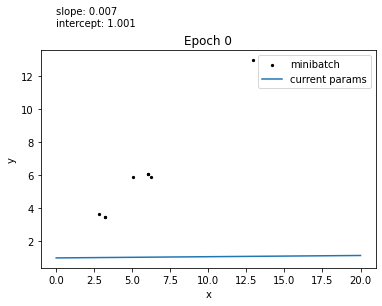

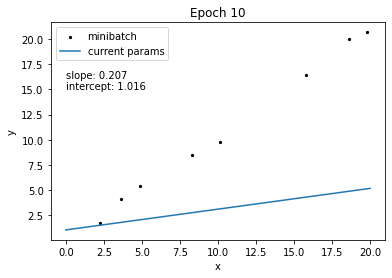

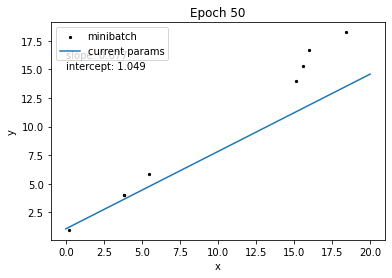

100 steps: loss 1.255 / gradnorm: 12.702


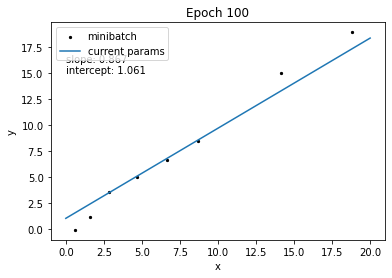

200 steps: loss 0.804 / gradnorm: 11.083
300 steps: loss 0.797 / gradnorm: 4.803
400 steps: loss 1.104 / gradnorm: 3.542
500 steps: loss 0.655 / gradnorm: 10.372


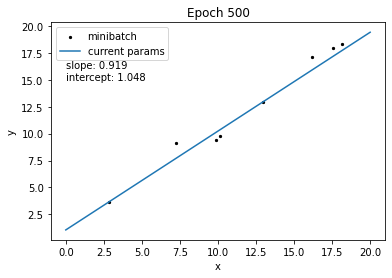

600 steps: loss 0.285 / gradnorm: 7.896
700 steps: loss 0.399 / gradnorm: 3.517
800 steps: loss 1.834 / gradnorm: 20.000
900 steps: loss 0.520 / gradnorm: 1.368


In [42]:
m_init = 0
c_init = 1
init_pars = jnp.array([m_init, c_init])
_pars = init_pars

eta = 1e-4
n_optimisation_steps = 1000
batch_size = 8

# because of how JAX randomness works, declare a key here for this cell.
sgd_rng_key = jax.random.PRNGKey(42)
dataset_idxs = jnp.arange(len(x))

loss_arr_stoch = jnp.zeros(n_optimisation_steps)
grad_arr_stoch = jnp.zeros(n_optimisation_steps)

for n in range(n_optimisation_steps):

    x_batch = jax.random.choice(sgd_rng_key, x, shape=(batch_size, ))
    y_batch = jax.random.choice(sgd_rng_key, y_obs, shape=(batch_size, ))
    _, sgd_rng_key = jax.random.split(sgd_rng_key)

    _loss_stoch = loss_function(_pars, x_batch, y_batch)
    loss_arr_stoch = loss_arr_stoch.at[n].set(_loss_stoch)

    _loss_grads_stoch = dloss_vec(_pars, x_batch, y_batch)
    grad_arr_stoch = grad_arr_stoch.at[n].set(jnp.linalg.norm(_loss_grads_stoch))
    _pars -= eta * _loss_grads_stoch

    if not (n % 100):
        print(f"{n} steps: loss {_loss_stoch:.3f} / gradnorm: {jnp.linalg.norm(_loss_grads_stoch):.3f}")

    # plot at specific intervals
    if n in [0, 10, 50, 100, 500, 1000, 2000]:
        _slope, _intercept = _pars
        plt.scatter(x_batch, y_batch, c='k', s=5, label='minibatch')
        plt.text(0, 15, f"slope: {_slope:.3f} \nintercept: {_intercept:.3f}")
        plt.plot(x, _intercept + _slope*x, label='current params')
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title(f"Epoch {n}")
        plt.legend()
        plt.show()


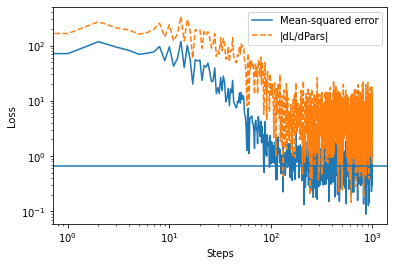

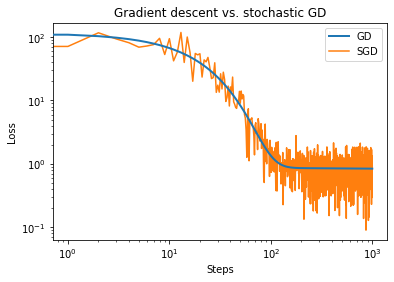

In [43]:
analytic_loss = loss_function([m_true, b_true], x, y_obs)

plt.plot(loss_arr_stoch, label='Mean-squared error')
plt.plot(grad_arr_stoch, ls='--', label='|dL/dPars|')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.axhline(analytic_loss)
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

plt.plot(loss_arr, zorder=20, lw=2, label='GD')
plt.plot(loss_arr_stoch, label='SGD')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.title("Gradient descent vs. stochastic GD")
plt.show()

So what does all of this have to do with machine learning?
---
- With this diversion we've covered how to build a (linear) model, choosing a loss function, optimising said loss function using stochastic gradient descent, and why we might want to do this.
- The next chunk of the notebook focuses on how we bridge from these basic linear models to building neural networks.

- In a sense we've already written the most basic neural network - it's just missing what we call an 'activation function' to make it non-linear. This is still not really machine learning - statisticians call this class of models 'generalised linear models' and they're useful for a wide variety of tasks.

Building a generalised linear model to estimate completeness in astronomical data
-----
Let's build a simple GLM to estimate the probability of having detected a given source in astronomical data. This is also known as [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) and is commonplace in statistics. There are already libraries that can do this for us, but that's no fun!

As input, our model takes some parameters (here the flux of a given object), and predicts as output the _probability_ of recovering a source at that magnitude. Our "labels" will have the form (magnitude, recovered) where magnitude is a continuous variable, and recovered is a binary 0/1 (or no/yes) label.

This model has no closed-form analytic solution and thus here we _need_ to use our gradient descent from above!

In [49]:
def logistic_function(pars, x):
    beta_0, beta_1 = pars
    return 1/(1 + jnp.exp(-(beta_0 + beta_1 * x)))

def loss_function(pars, x, y):
    model_preds = logistic_function(pars, x)
    xent_loss = -y * jnp.log(model_preds) - (1 - y) * jnp.log(1 - model_preds)
    return jnp.sum(xent_loss)

Key takeaway:
---
This is just a linear model wrapped in a non-linear function, e.g. $\sigma(z)$, where $z = \beta_0 + \beta_1 x$

The neuron
---
- Neurons are the simplest possible unit of a fully-connected neural network. They look very similar to the linear model we just created - the terminology is slightly different but the principles are the same.
- Neurons take inputs, multiply them by a weight and sum, apply a bias term, and then 'rectify' the output using an 'activation function'
- Our linear models take inputs, multiply them by coefficients (the 'slopes' $m_i$), add a bias term (the 'intercepts' $b_i$), and sum this to get the output variable.

Mathematically, we can write the 'forward pass' as:
$ z_j = \sum_{k} w_{jk} y^{in}_{k} + b_{j}$
$ y^{out}_{j} = f(z_j)$
where $k$ represents the number of inputs, and $j$ represents the number of outputs

Below I define a simple Python class to implement this. If you aren't familiar with Python classes don't worry, I've added annotations below to help with your understanding. Python classes provide a nice way to manage _state_, and define methods to operate on class attributes.

In [189]:
no_activation = lambda z_in: z_in

class NeuronLayer:
    # the `__init__` method creates the Neuron.
    def __init__(self, input_size, output_size, activation_function=None):
        self.weights = jnp.ones((output_size, input_size))
        self.bias = jnp.ones(output_size)
        self.activation_function = activation_function if activation_function is not None else no_activation

    def forward_pass(self, inputs):
        z = self.weights @ inputs + self.bias
        return self.activation_function(z)

    def __call__(self, inputs):
        return self.forward_pass(inputs=inputs)

In [190]:
_neuron = NeuronLayer(input_size=1, output_size=1)
x_in = jnp.array([1])
y_out = _neuron(x_in)

# change the bias to 0 to recover our linear model
_neuron.bias = jnp.array([0])
print(x_in, _neuron(x_in))

[1] [1.]


Hidden layers
---
Now let's build a fully-fledged neural network! For this demo, we'll learn to approximate a quadratic function. This technique is overkill, but hopefully hammers home that machine learning doesn't have to be used for classifying cats and dogs - in a sense, neural networks are just (very!) high dimensional function interpolators.

In [50]:


class NeuralNetwork:
    def __init__(self, input_size, hidden_layer_neurons, output_size):
        self.layers = [NeuronLayer(input_size=input_size, output_size=hidden_layer_neurons), NeuronLayer(input_size=hidden_layer_neurons, output_size=output_size)]
        self.weights = [layer.weights for layer in self.layers]
        self.biases = [layer.bias for layer in self.layers]
        rng_key = jax.random.PRNGKey(1234)
        self.weights = [jax.random.normal(rng_key := jax.random.split(rng_key)[1], shape=w.shape) for w in self.weights]
        self.biases = [jax.random.normal(rng_key := jax.random.split(rng_key)[1], shape=w.shape) for w in self.biases]

    def feed_forward(self, inputs):
        return feed_forward(inputs, weights=self.weights, biases=self.biases)

    def __call__(self, inputs):
        return self.feed_forward(inputs)

    def compute_loss(self, inputs, outputs):
        return jnp.mean(jnp.square(_compute_loss(inputs=inputs, outputs=outputs, weights=self.weights, biases=self.biases)))

    def loss_and_grads(self, inputs, outputs):
        return loss_and_grads(inputs, outputs, self.weights, self.biases)


def feed_forward(inputs, weights, biases):
    _yout = inputs
    for w, b in zip(weights, biases):
        _yout = w @ _yout + b
        _yout = _yout

    return _yout

def _compute_loss(inputs, outputs, weights, biases):
    return jnp.mean(jnp.square(feed_forward(inputs=inputs, weights=weights, biases=biases) - outputs))

loss_and_grads = jax.value_and_grad(_compute_loss, argnums=(2, 3))

In [170]:
nn = NeuralNetwork(input_size=1, hidden_layer_neurons=30, output_size=1)

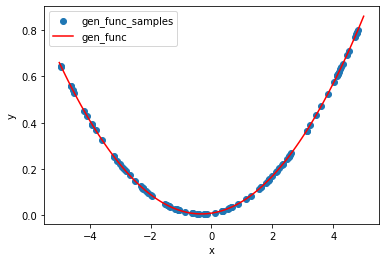

In [185]:
def gen_func(x_gen):
    return (1 + 2 * x_gen + 3 * x_gen * x_gen)/100

x_test = 10 * (jax.random.uniform(rng_key, shape=(100,)) - 0.5)
y_test = gen_func(x_test)

plt.scatter(x_test, y_test, label='gen_func_samples')
plt.plot(x_plot := jnp.linspace(-5, 5, 100), gen_func(x_plot), c='r', label='gen_func')
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

121.44687422136691
37.33926567953259
18.289093472544366
12.856795602978899
10.57621028638328
9.069421534456813
7.856296454912485
6.831236814153915
5.941072105522956
5.166318045334683
4.5022418930754045
3.917417668355168
3.4154695718447043
2.973393749057309
2.5890167481892137
2.254118437680839
1.9693820451380788
1.718611755801352
1.4989606080462647
1.3093524404786052
1.1461788017702788
1.0019952481838932
0.8776553458439748
0.7694497200475595
0.6749425980806498
0.593560634218725
0.5216438908510351
0.46020836410457194
0.4072090728620039
0.359893602546475
0.31986646084164716
0.28469636905353357
0.25407198013050747
0.2274824968385084
0.20419431239713196
0.18425767243835078
0.16652334974939584
0.15153824724955203
0.13843725767068918
0.12685655442421923
0.11708600254612726
0.10840275185750224
0.10087671774967377
0.09424926899922083
0.08830875324389026
0.08361409554932704
0.0795579025424186
0.07585690687461102
0.07251848431611625
0.0696787859657258


Text(0, 0.5, 'MSE loss')

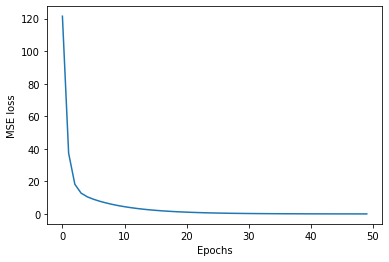

In [189]:
n_passes = 50
eta = 1e-5

nn = NeuralNetwork(input_size=1, hidden_layer_neurons=20, output_size=1)

loss_vals = []

train_rng_key, _ = jax.random.split(rng_key)
for n in range(n_passes):
    x_shuf = jax.random.permutation(train_rng_key, x_test, independent=True)
    y_shuf = jax.random.permutation(train_rng_key, y_test, independent=True)
    train_rng_key, _ = jax.random.split(train_rng_key)
    lavg = 0
    gavg = []
    for _x, _y in zip(x_shuf, y_shuf):
        val, grad = nn.loss_and_grads(jnp.atleast_1d(_x), jnp.atleast_1d(_y))
        nn.weights = [wold - eta * g for wold, g in zip(nn.weights, grad[0])]
        nn.biases = [wold - eta * g for wold, g in zip(nn.biases, grad[1])]
        lavg += val
        gavg.append(grad)
    loss = lavg / x_shuf.shape[0]
    print(loss)
    loss_vals.append(loss)


plt.plot(loss_vals)
plt.xlabel("Epochs")
plt.ylabel("MSE loss")

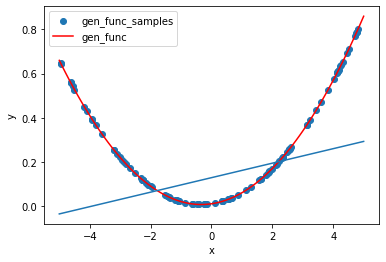

In [190]:
y_pred = jnp.array([nn.feed_forward(jnp.atleast_1d(x)) for x in x_plot])
plt.scatter(x_test, y_test, label='gen_func_samples')
plt.plot(x_plot := jnp.linspace(-5, 5, 100), gen_func(x_plot), c='r', label='gen_func')
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.plot(x_plot, y_pred)

In [196]:
feed_forward(jnp.atleast_1d(2), nn.weights, nn.biases)

DeviceArray([0.1940728], dtype=float64)